# 04-Data Preprocessing & Weight Initialization

[1.Data Preprocessing](#1)
  - [1-1.Centering](#1-1)
  - [1-2.Normalization](#1-2)

[2.Weight Initialization](#2)
  - [2-1. 0으로 초기화](#2-1)
  - [2-2. Random Initialization](#2-2)

[3. Xavier Initialization](#3)

[4. He Initialization](#4)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

<a id="1"></a>
## 1.Data Preprocessing

In [2]:
data = pd.read_csv("./data/weight-height.csv")
print(data.shape)
print(data.head())

(10000, 3)
  Gender     Weight      Height
0   Male  73.847017  241.893563
1   Male  68.781904  162.310473
2   Male  74.110105  212.740856
3   Male  71.730978  220.042470
4   Male  69.881796  206.349801


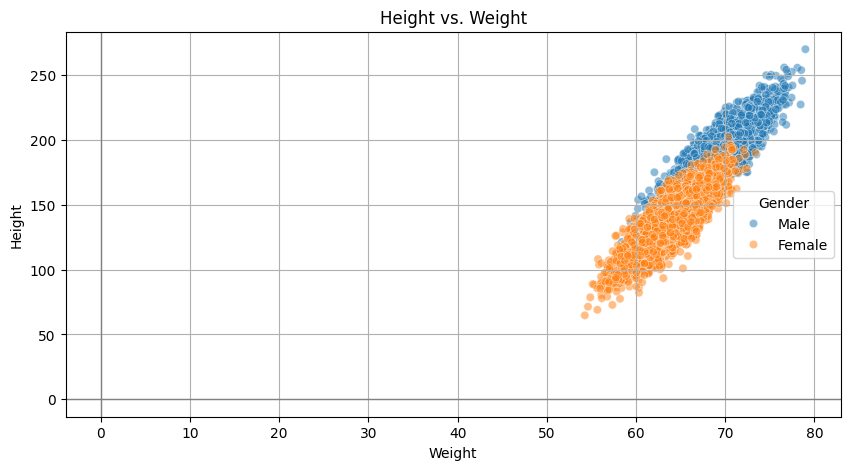

In [3]:
# Zero-Centering 데이터 시각화
plt.figure(figsize=(10, 5))

# 키와 몸무게의 Zero-Centered 데이터 분포
sns.scatterplot(x='Weight', y='Height', data=data, hue='Gender', alpha=0.5)
plt.title('Height vs. Weight')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)

plt.show()


<a id="1-1"></a>
### Centering

In [4]:
mean_height = data['Height'].mean()
mean_weight = data['Weight'].mean()

data['Height_centered'] = data['Height'] - mean_height
data['Weight_centered'] = data['Weight'] - mean_weight

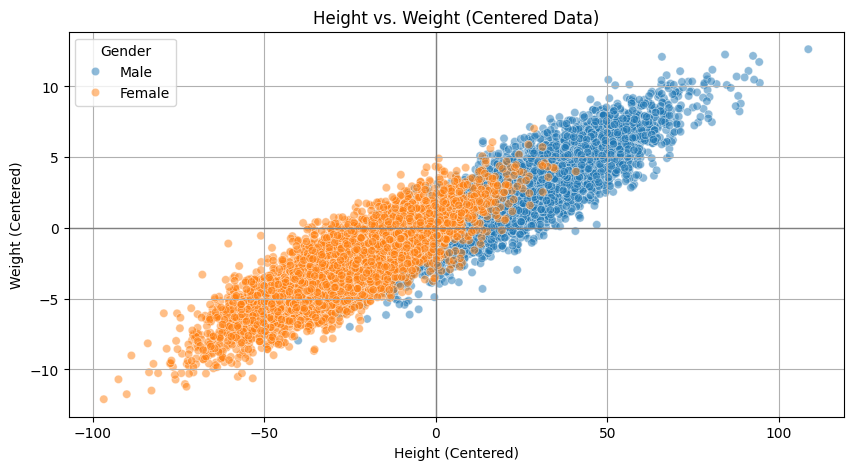

In [5]:
# Zero-Centering 데이터 시각화
plt.figure(figsize=(10, 5))

# 키와 몸무게의 Zero-Centered 데이터 분포
sns.scatterplot(x='Height_centered', y='Weight_centered', data=data, hue='Gender', alpha=0.5)
plt.title('Height vs. Weight (Centered Data)')
plt.ylabel('Weight (Centered)')
plt.xlabel('Height (Centered)')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)

plt.show()


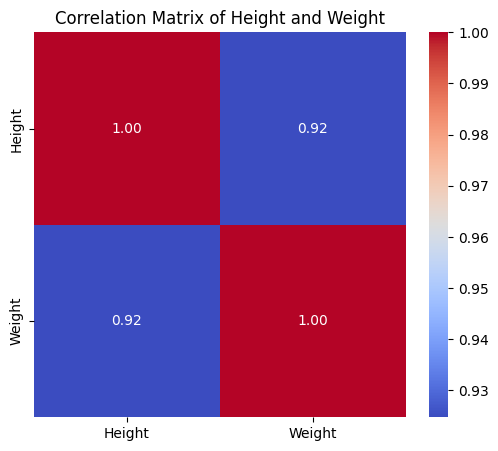

In [6]:
correlation_matrix = data[['Height', 'Weight']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Height and Weight')
plt.show()


<a id="1-2"></a>
### 1-2.Normalization

Text(0.5, 0, 'Weight (Min-Max Normalized)')

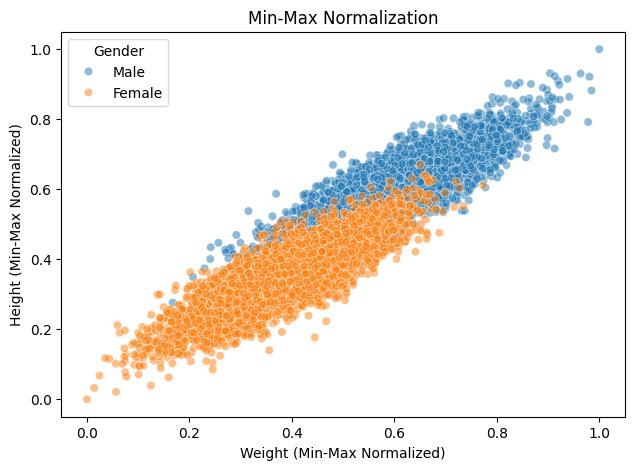

In [7]:
data['Height_min_max'] = (data['Height'] - data['Height'].min()) / (data['Height'].max() - data['Height'].min())
data['Weight_min_max'] = (data['Weight'] - data['Weight'].min()) / (data['Weight'].max() - data['Weight'].min())

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Weight_min_max', y='Height_min_max', data=data, hue='Gender', alpha=0.5)
plt.title('Min-Max Normalization')
plt.ylabel('Height (Min-Max Normalized)')
plt.xlabel('Weight (Min-Max Normalized)')

<a id="2"></a>
## 2. Weight Initialization

<a id="2-1"></a>
### 2-1. 0으로 초기화

In [8]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [9]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.zeros((input_size, layer_widths[0]))] ## first hidden layer

        for i in range(self.layers - 1): ## second ~ nth hidden layers
            weight = np.zeros((layer_widths[i], layer_widths[i+1]))
            self.weights.append(weight)

        self.weights += [np.zeros((layer_widths[i], 1))] ## output layer

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net)) ## sigmoid -> relu

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y] ## loss
        
        # 역전파: 그래디언트 계산
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1]) ## dL/d(hat y)  * da/dz
            gradients.append(np.dot(activations[i].T, delta)) ## dL/dz * dz/dw = dL/dz * x^T
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

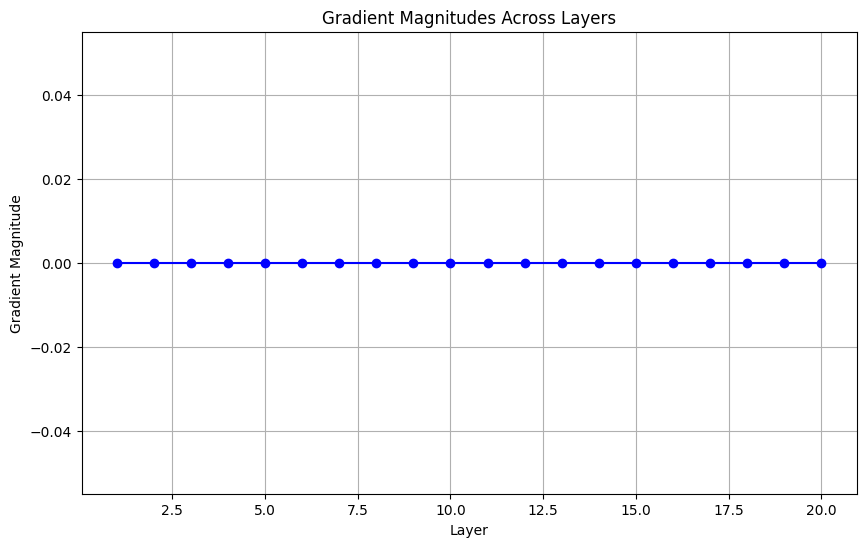

In [10]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="2-2"></a>
### 2-2. Random Initialization

먼저, 평균이 0이고 표준편차가 0.01인 정규분포를 따르는 random weight를 사용해서 테스트.

In [11]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0]) * 0.01]

        for i in range(self.layers - 1):
            weight = np.random.randn(layer_widths[i], layer_widths[i+1]) * 0.01 
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1) * 0.01]

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net))

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y]
        
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1])
            gradients.append(np.dot(activations[i].T, delta))
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

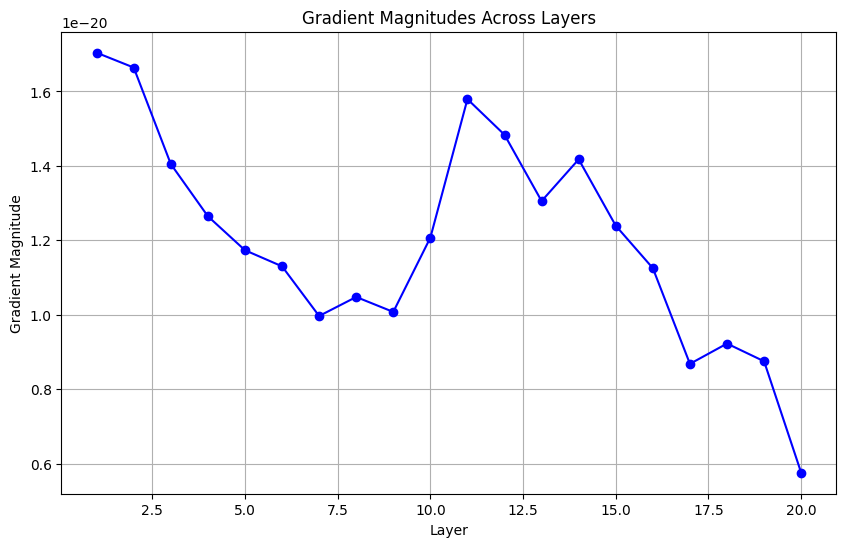

In [12]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

In [13]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0]) * 100]

        for i in range(self.layers - 1):
            weight = np.random.randn(layer_widths[i], layer_widths[i+1]) * 100
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1) * 100]

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net))

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y]
        
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1])
            gradients.append(np.dot(activations[i].T, delta))
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

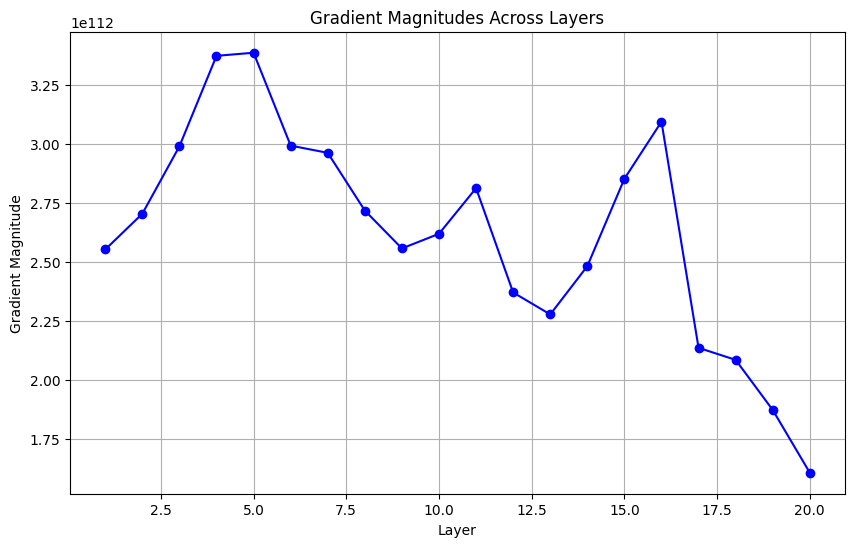

In [14]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="3"></a>
## 3. Xavier Initialization

In [15]:
input_size = 5
layer_depths = 3
layer_widths = [4, 4, 3]

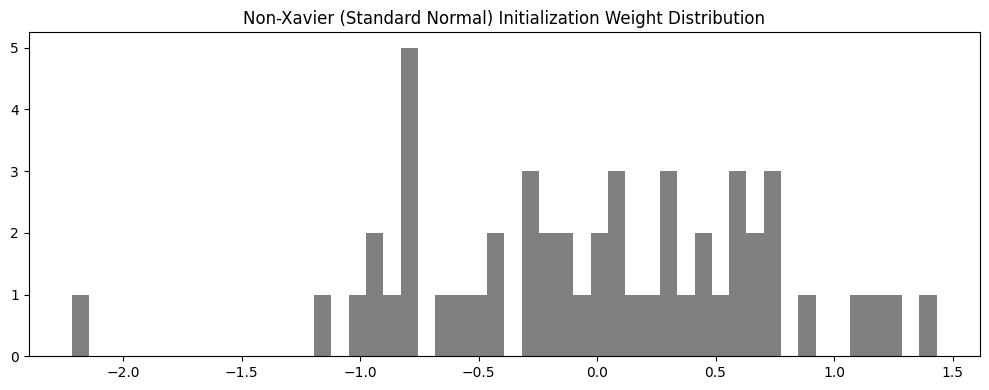

In [16]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = []

        # Non-Xavier initialization (standard normal distribution)
        for i in range(self.layers):
            if i == 0: # First hidden layer
                shape = (input_size, layer_widths[0])
            else: # Subsequent hidden layers
                shape = (layer_widths[i-1], layer_widths[i])
            weight = np.random.randn(*shape)
            self.weights.append(weight)

        # Output layer
        if self.layers > 0:
            shape = (layer_widths[-1], 1)
        else: # If no hidden layers
            shape = (input_size, 1)
        weight = np.random.randn(*shape)
        self.weights.append(weight)

# Generate data for plots
nn_non_xavier = SimpleNeuralNetwork(input_size, layer_depths, layer_widths)

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))

# Non-Xavier distribution weights
all_weights_non_xavier = np.concatenate([w.flatten() for w in nn_non_xavier.weights])
ax.hist(all_weights_non_xavier, bins=50, color='gray')
ax.set_title('Non-Xavier (Standard Normal) Initialization Weight Distribution')

plt.tight_layout()
plt.show()


In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def xavier_uniform(shape, gain=1):
    fan_in, fan_out = shape[0], shape[1]
    limit = gain * np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=shape)

def xavier_normal(shape, gain=1):
    fan_in, fan_out = shape[0], shape[1]
    std = gain * np.sqrt(2 / (fan_in + fan_out))
    return np.random.normal(0, std, size=shape)

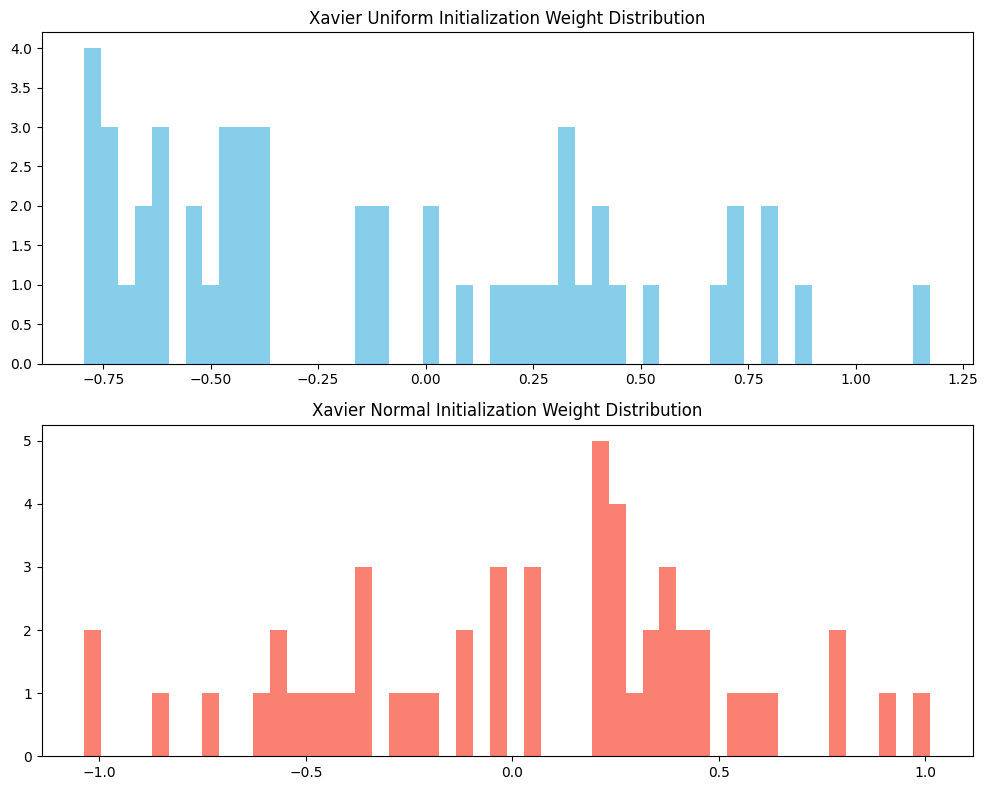

In [18]:
class SimpleNeuralNetworkXavier:
    def __init__(self, input_size, layer_depths, layer_widths, init_type='uniform'):
        self.layers = layer_depths
        self.weights = []
        self.init_type = init_type

        # Xavier initialization
        for i in range(self.layers):
            if i == 0: # First hidden layer
                shape = (input_size, layer_widths[0])
            else: # Subsequent hidden layers
                shape = (layer_widths[i-1], layer_widths[i])

            if init_type == 'uniform':
                weight = xavier_uniform(shape)
            else: # normal
                weight = xavier_normal(shape)
            self.weights.append(weight)

        # Output layer
        if self.layers > 0:
            shape = (layer_widths[-1], 1)
        else: # If no hidden layers
            shape = (input_size, 1)
        
        if init_type == 'uniform':
            weight = xavier_uniform(shape)
        else: # normal
            weight = xavier_normal(shape)
        self.weights.append(weight)

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")


nn_uniform = SimpleNeuralNetworkXavier(input_size, layer_depths, layer_widths, 'uniform')
nn_normal = SimpleNeuralNetworkXavier(input_size, layer_depths, layer_widths, 'normal')

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
all_weights_uniform = np.concatenate([w.flatten() for w in nn_uniform.weights])
axes[0].hist(all_weights_uniform, bins=50, color='skyblue')
axes[0].set_title('Xavier Uniform Initialization Weight Distribution')

all_weights_normal = np.concatenate([w.flatten() for w in nn_normal.weights])
axes[1].hist(all_weights_normal, bins=50, color='salmon')
axes[1].set_title('Xavier Normal Initialization Weight Distribution')

plt.tight_layout()
plt.show()


<a id="4"></a>
## 4. He Initialization

In [19]:
input_size = 5
layer_depths = 3
layer_widths = [4, 4, 3]

In [20]:
class SimpleNeuralNetworkHe:
    def __init__(self, input_size, layer_depths, layer_widths, init_type='normal'):
        self.layers = layer_depths
        self.weights = []
        self.init_type = init_type

        # He initialization
        for i in range(self.layers):
            if i == 0:  # First hidden layer
                shape = (input_size, layer_widths[0])
            else:  # Subsequent hidden layers
                shape = (layer_widths[i-1], layer_widths[i])

            if init_type == 'uniform':
                weight = self.he_uniform(shape)
            else:  # normal
                weight = self.he_normal(shape)
            self.weights.append(weight)

        # Output layer
        if self.layers > 0:
            shape = (layer_widths[-1], 1)
        else:  # If no hidden layers
            shape = (input_size, 1)

        if init_type == 'uniform':
            weight = self.he_uniform(shape)
        else:  # normal
            weight = self.he_normal(shape)
        self.weights.append(weight)

    def he_normal(self, shape):
        std = np.sqrt(2. / shape[0])  # fan_in
        return np.random.normal(0, std, size=shape)

    def he_uniform(self, shape):
        limit = np.sqrt(6. / shape[0])  # fan_in
        return np.random.uniform(-limit, limit, size=shape)

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

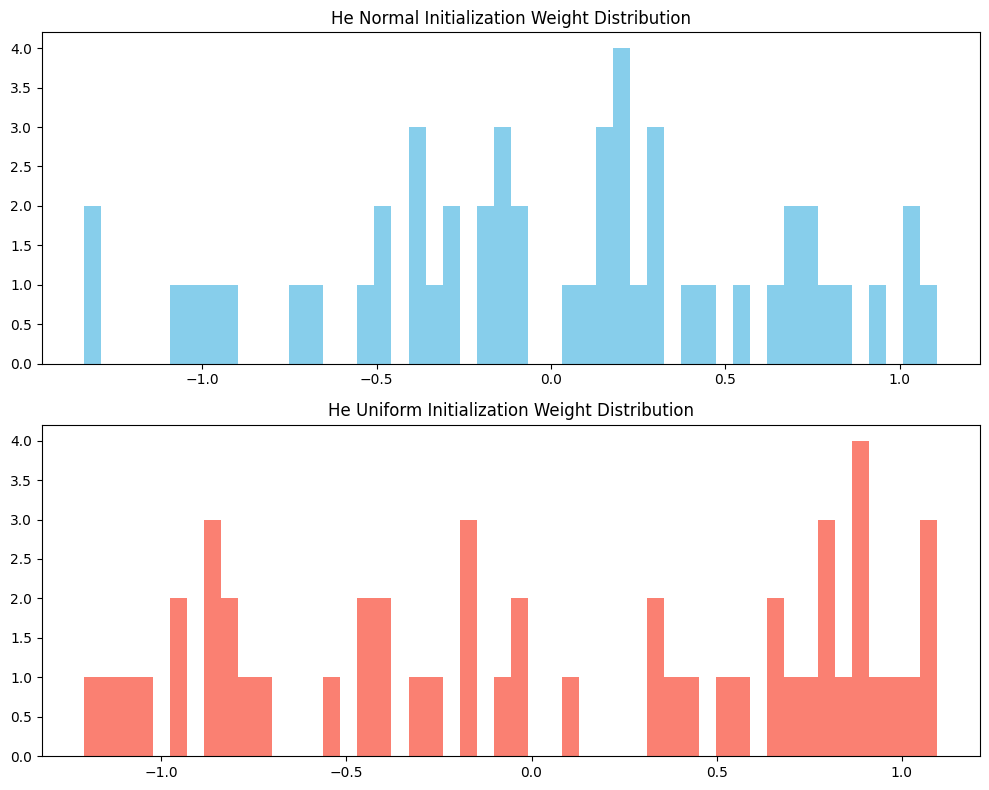

In [21]:
nn_he_normal = SimpleNeuralNetworkHe(input_size, layer_depths, layer_widths, 'normal')
nn_he_uniform = SimpleNeuralNetworkHe(input_size, layer_depths, layer_widths, 'uniform')

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
all_weights_he_normal = np.concatenate([w.flatten() for w in nn_he_normal.weights])
axes[0].hist(all_weights_he_normal, bins=50, color='skyblue')
axes[0].set_title('He Normal Initialization Weight Distribution')

all_weights_he_uniform = np.concatenate([w.flatten() for w in nn_he_uniform.weights])
axes[1].hist(all_weights_he_uniform, bins=50, color='salmon')
axes[1].set_title('He Uniform Initialization Weight Distribution')

plt.tight_layout()
plt.show()


In [22]:
df = pd.read_csv("/home/pervinco/DL-basic/data/Social_Network_Ads.csv")
df['Gender'] = (df['Gender'] =='Male').astype(int)

y = df['Purchased']
df = df.drop(columns = ['User ID','Purchased'])

In [23]:
train_x, test_x, train_y, test_y = train_test_split(df, y, test_size=0.1, random_state=0)

train_x = np.array(train_x).T
train_y = np.expand_dims(train_y, axis=0)

test_x = np.array(test_x).T
test_y = np.expand_dims(test_y, axis=0)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(3, 360) (1, 360)
(3, 40) (1, 40)


In [24]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    ## Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_mini_batches = math.floor(m / mini_batch_size)
    for k in range(0, num_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    ## 마지막 미니배치의 크기가 batch_size와 다른 경우. 나머지 데이터들을 묶어서 미니 배치를 생성.
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_mini_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_mini_batches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [25]:
def initialize_parameters_he(layers_dims):  
    ## He Normal Distribution을 따라 확률 변수들에 확률을 부여하고, 랜덤으로 가중치 값을 선정.
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

In [26]:
def forward_propagation(X, parameters):
    """
    Arguments:
     - X : input data (n_x, m) n_x는 feature 수, m은 데이터 샘플 수
     - parameters : 각 layer의 trainable params dict타입 {"W1", "b1", ..., "WL", "bL"}

    Returns:
     - AL : 출력층(L번째 layer)의 activation feature
     - caches : 각 층의 (input, weight, bias, output)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    # [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)  # ReLU
        cache = (A_prev, W, b, Z)
        caches.append(cache)
        
    # LINEAR -> SIGMOID
    WL = parameters['W' + str(L)]
    bL = parameters['b' + str(L)]
    ZL = np.dot(WL, A) + bL
    AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
    cache = (A, WL, bL, ZL)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [27]:
def compute_cost(AL, Y):
    """
    Arguments:
     - AL : label 예측에 해당하는 확률 벡터. (1, num of data samples)
     - Y : ground-truth 벡터. (1, num of data samples)

    Returns:
     - cost : cross-entropy cost
    """
    m = Y.shape[1]

    # logprobs = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
    logprobs = np.multiply(np.log(AL + 1e-8), Y) + np.multiply((1 - Y), np.log(1 - AL + 1e-8))

    cost = -np.sum(logprobs) / m

    cost = float(np.squeeze(cost))

    return cost

In [28]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, Z):
    S = sigmoid(Z)
    dZ = dA * S * (1-S)

    return dZ

def backward_propagation(X, Y, caches, AL):
    """
    Backward Propagation.
    L-1개의 [Linear -> ReLU] layer와 출력층 [Linear -> Sigmoid]의 parameter에 대한 gradient를 계산한다.

    Arguments:
     - X : 입력 데이터. (n_x, m) n_x는 feature 수, m은 데이터 샘플의 수
     - Y : ground_truth. (1, m)
     - caches : list 타입. 각 layer의 (input, weight, bias, output).
     - AL : 마지막 출력층의 출력값. y hat.
    """
    grads = {}
    L = len(caches) ## layer 수
    m = X.shape[1] ## 데이터 샘플의 수

    ## cost function gradient
    # dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    dAL = -(np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))

    ## L번째 layer(출력층) [sigmoid -> Linear] gradient
    cache = caches[-1]
    A_prev, WL, bL, ZL = cache
    dZL = sigmoid_backward(dAL, ZL) ## dL/dA * dA/dZ = dL / dZ
    dWL = np.dot(dZL, A_prev.T) ## dL/dZ * dZ/dW = dL/dW
    dbL = np.sum(dZL, axis=1, keepdims=True) / m ## dL/dZ * dZ/db = dL/db
    dA_prev = np.dot(WL.T, dZL) ## dL/dZ * dZ/dX = dL/dX

    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL

    for l in reversed(range(L-1)):
        cache = caches[l]
        A_prev, W, b, Z = cache
        dZ = relu_backward(grads["dA" + str(l + 2)], Z)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads

In [29]:
def update_parameters_with_gradient_descent(parameters, grads, learning_rate):
    """
    Gradient Descent 방식으로 parameter를 업데이트.

    Arguments:
     - parameters : dict 타입. layer에 설정된 weight, bias
     - grads : dict 타입. 각 parameter에 대한 gradients
     - learning rate : 실수형. 

    Returns:
     - parameters : dict 타입. gradient로 업데이트된 parameters
    """
    L = len(parameters) // 2 ## nn을 구성하는 layer 수

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters

In [30]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_he(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.011552
Cost after epoch 1000: 0.011034
Cost after epoch 2000: 0.011065
Cost after epoch 3000: 0.011039
Cost after epoch 4000: 0.011039


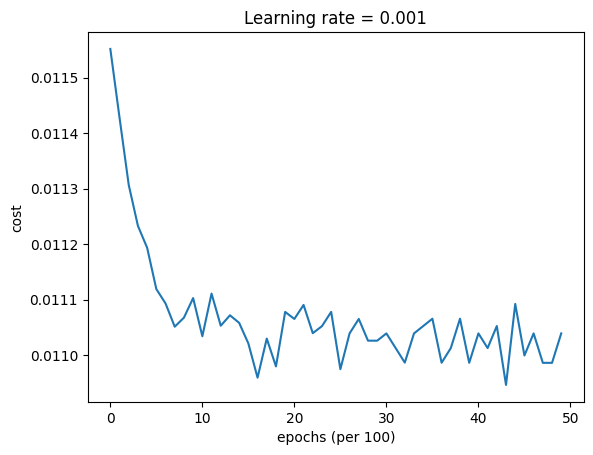

In [31]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)